# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/7DDxnD

Contact: ntu-ml-2022spring-ta@googlegroups.com


## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

```bash
# set up environment
import sys
!{sys.executable} -m pip install pytorchcv
!{sys.executable} -m pip install imgaug

# download
!wget https://github.com/DanielLin94144/ML-attack-dataset/files/8167812/data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip
```

In [1]:
from typing import List

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if str(device) == 'cpu':
    raise RuntimeError("cuda is NOT available!!")
batch_size = 8

RuntimeError: cuda is NOT available!!

## Global Settings 
#### **[NOTE]**: Don't change the settings here, or your generated image might not meet the constraint.
* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [ ]:
# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

In [ ]:
root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [ ]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(cifar_10_mean, cifar_10_std)  # Normalize the image using predefined means and standard deviations
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []  # List to store image paths
        self.labels = []  # List to store corresponding labels
        self.names = []  # List to store the relative paths of images
        
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        
        # Iterate over class directories in the given data directory
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))  # Get a list of image paths in each class directory
            self.images += images  # Append the image paths to the list
            self.labels += ([i] * len(images))  # Assign labels to the images based on the class index
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]  # Get the relative paths of the images
        
        self.transform = transform  # Transformation to be applied to each image
    
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))  # Load and transform the image at the given index
        label = self.labels[idx]  # Get the corresponding label
        return image, label  # Return the transformed image and its label
    
    def __getname__(self):
        return self.names  # Return the list of image names
    
    def __len__(self):
        return len(self.images)  # Return the total number of images in the dataset

adv_set = AdvDataset(root, transform=transform)  # Create an instance of the AdvDataset
adv_names = adv_set.__getname__()  # Get the list of image names from the dataset
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)  # Create a data loader for the dataset

print(f'number of images = {adv_set.__len__()}')  # Print the total number of images in the dataset

## Utils -- Benign Images Evaluation

In [ ]:
# to evaluate the performance of the model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    train_acc, train_loss = 0.0, 0.0  # Initialize accuracy and loss variables

    # Iterate over the data loader
    for x, y in loader:  # x: image, y: label
        x, y = x.to(device), y.to(device)  # Move the input data to the appropriate device (e.g., GPU)
        yp = model(x)  # Forward pass through the model to get predictions
        loss = loss_fn(yp, y)  # Compute the loss between predictions and ground truth labels
        train_acc += (yp.argmax(dim=1) == y).sum().item()  # Count correct predictions and add them to the accuracy
        train_loss += loss.item() * x.shape[0]  # Multiply the loss by batch size and add it to the total loss

    # Calculate the average accuracy and loss per sample
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [ ]:
# perform fgsm attack
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x, by creating a clone of the input tensor 'x' and detach it from the computation graph
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    loss = loss_fn(model(x_adv), y) # calculate loss
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    grad = x_adv.grad.detach() # Compute gradients of the loss with respect to 'x_adv'
    x_adv = x_adv + epsilon * grad.sign() # Create an adversarial example by adding a perturbation in the direction of the sign of the gradients
    return x_adv

# num_iter can be decided by yourself
def ifgsm(model, x, y, loss_fn, epsilon:float=epsilon, num_iter:int=20):
    if num_iter < 1:
        raise RuntimeError(f"num_iter, {num_iter}, needs to be greater than 0!") 
    alpha = epsilon / num_iter
    x_adv = x
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        # x_adv = fgsm(model, x_adv, y, loss_fn, alpha) # call fgsm with (epsilon = alpha) to obtain new x_adv
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # fgsm: use gradient ascent on x_adv to maximize loss
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()

        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

def mifgsm(model, x, y, loss_fn, epsilon=epsilon, num_iter=20, decay=1.0):
    if num_iter < 1:
        raise RuntimeError(f"num_iter, {num_iter}, needs to be greater than 0!") 
    alpha = epsilon / num_iter
    x_adv = x
    # initialze momentum tensor
    momentum = torch.zeros_like(x).detach().to(device)
    # write a loop of num_iter to represent the iterative times
    for i in range(num_iter):
        x_adv = x_adv.detach().clone()
        x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
        loss = loss_fn(model(x_adv), y) # calculate loss
        loss.backward() # calculate gradient
        # TODO: Momentum calculation
        # import ipdb; ipdb.set_trace()
        grad = x_adv.grad.detach()
        momentum = decay * momentum + grad / torch.norm(grad, p=1)
        # x_adv = x_adv + alpha * grad.sign()
        x_adv = x_adv + alpha * momentum.sign()
        x_adv = torch.max(torch.min(x_adv, x+epsilon), x-epsilon) # clip new x_adv back to [x-epsilon, x+epsilon]
    return x_adv

## Utils -- Attack
* Recall
  * ToTensor() can be seen as a function where $T(x) = x/255$.
  * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
  * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
  * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
  * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
  * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [ ]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, loader, attack, loss_fn):
    model.eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, x, y, loss_fn) # obtain adversarial examples
        yp = model(x_adv)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        '''
        If it's not the first iteration, np.r_ is used to concatenate the new adversarial 
        examples (adv_ex) with the existing ones (adv_examples) along the first axis (bs). 
        This results in adv_examples containing all the adversarial examples generated so far.
        '''
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:  # Check if the adversarial directory already exists
        shutil.rmtree(adv_dir)
        _ = shutil.copytree(data_dir, adv_dir)  # Create a new directory by copying the original data (benign copies) directory

    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8))  # Convert the example array to an image with unsigned integer pixel values
        im.save(os.path.join(adv_dir, name))  # Save the image in the adversarial directory with the given name

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

Here's a list and they each might have different variances:
```
densenet
diapreresnet
diaresnet
fractalnet
msdnet
nin
preresnet
pyramidnet
resdropresnet
resnet
resnext
rir
ror3
sepreresnet
seresnet
shakedropresnet
shakeshakeresnet
wrn
xdensenet
```

In [ ]:
def get_model_list(model_list_file:str)->List[str]:
    model_list = []
    with open(model_list_file, 'r') as f:
        model_name = f.readline().strip()
        while len(model_name)>0:
            model_list.append(model_name)
            model_name = f.readline().strip()
    return model_list

### Choose effective models

#### Load and inference for each model

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import time

tic0 = time.time()
model_list = get_model_list('cifar10_models.lst')
models = []
print(f"Loading all {len(model_list)} models.")
tic = time.time()
for model_name in model_list:
    model = ptcv_get_model(model_name, pretrained=True).to(device)
    models.append(model)
toc = time.time()
print(f"Total time for model loading: {toc-tic:.2f} seconds.")
loss_fn = nn.CrossEntropyLoss()

model_test_result = {}

In [ ]:
print(f"Inference for each model")
for model, model_name in zip(models, model_list):
    tic = time.time()
    model_test_result[f'{model_name}'] = list(epoch_benign(model, adv_loader, loss_fn)) + [model_name]
    toc = time.time()
    print(f"Time consumed: {toc-tic:.2f} seconds, for inference by model: {model_name}")

toc0 = time.time()
print(f"Total time consumed: {toc0-tic0:.1f} seconds.")

#### Final chosen models: `chosen_model_list`

In [ ]:
sorted_model_test_result = sorted(model_test_result.items(), key=lambda x: x[1][1], reverse=False)
sorted_model_test_result = [{k: v} for k, v in sorted_model_test_result]
print(sorted_model_test_result)
NUM_CHOSEN_MODELS = len(sorted_model_test_result) // 4 # len(sorted_model_test_result)
chosen_model_names = [next(iter(c.keys())) for c in sorted_model_test_result[:NUM_CHOSEN_MODELS]]
print(chosen_model_names)
chosen_model_list = [ptcv_get_model(m, pretrained=True).to(device) for m in chosen_model_names]
print([type(m) for m in chosen_model_list])

## FGSM

In [ ]:
%%time
fgsm_result = {}
for model, model_name in zip(chosen_model_list, chosen_model_names):
    adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
    print(f'fgsm_acc = {fgsm_acc:.2%}, fgsm_loss = {fgsm_loss:.5f} for model: {model_name}')
    fgsm_result[model] = [fgsm_acc, fgsm_loss, model_name]

sorted_fgsm_result = sorted(fgsm_result.items(), key=lambda x: x[1][0], reverse=False)

In [ ]:
print([{m[1][-1]:m[1][:-1]} for m in sorted_fgsm_result])

In [ ]:
%%time
model = sorted_fgsm_result[0][0]
model_name = sorted_fgsm_result[0][1][-1]
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.2%}, fgsm_loss = {fgsm_loss:.5f}, model = {model_name} ({type(model)})')

create_dir(root, 'fgsm', adv_examples, adv_names)

## I-FGSM

In [ ]:
%%time
ifgsm_result = {}
for model, model_name in zip(chosen_model_list, chosen_model_names):
    tic = time.time()
    adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
    toc = time.time()
    print(f'Time consumed: {toc-tic:.1f} seconds, ifgsm_acc = {ifgsm_acc:.2%}, ifgsm_loss = {ifgsm_loss:.5f} for model: {model_name}')
    ifgsm_result[model] = [ifgsm_acc, ifgsm_loss, model_name]

sorted_ifgsm_result = sorted(ifgsm_result.items(), key=lambda x: x[1][0], reverse=False)

In [ ]:
print([{m[1][-1]:m[1][:-1]} for m in sorted_ifgsm_result])

In [ ]:
%%time
model = sorted_ifgsm_result[0][0]
model_name = sorted_ifgsm_result[0][1][-1]
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, adv_loader, ifgsm, loss_fn)
print(f'ifgsm_acc = {ifgsm_acc:.2%}, ifgsm_loss = {ifgsm_loss:.5f}, model = {model_name} ({type(model)})')

create_dir(root, 'ifgsm', adv_examples, adv_names)

## MI-FGSM

In [ ]:
%%time
mifgsm_result = {}
for model, model_name in zip(chosen_model_list, chosen_model_names):
    tic = time.time()
    adv_examples, mifgsm_acc, mifgsm_loss = gen_adv_examples(model, adv_loader, mifgsm, loss_fn) # Use mifgsm as the algorithm
    toc = time.time()
    print(f'Time consumed: {toc-tic:.1f} seconds, mifgsm_acc = {mifgsm_acc:.2%}, mifgsm_loss = {mifgsm_loss:.5f} for model: {model_name}')
    mifgsm_result[model] = [mifgsm_acc, mifgsm_loss, model_name]

sorted_mifgsm_result = sorted(mifgsm_result.items(), key=lambda x: x[1][0], reverse=False)

In [ ]:
print([{m[1][-1]:m[1][:-1]} for m in sorted_mifgsm_result])

In [ ]:
%%time
model = sorted_mifgsm_result[0][0]
model_name = sorted_mifgsm_result[0][1][-1]
adv_examples, mifgsm_acc, mifgsm_loss = gen_adv_examples(model, adv_loader, mifgsm, loss_fn)
print(f'mifgsm_acc = {mifgsm_acc:.2%}, mifgsm_loss = {mifgsm_loss:.5f}, model = {model_name} ({type(model)})')

create_dir(root, 'mifgsm', adv_examples, adv_names)

## Example of Ensemble Attack
* Ensemble multiple models as your proxy model to increase the black-box transferability ([paper](https://arxiv.org/abs/1611.02770))

In [ ]:
class ensembleNet(nn.Module):
    def __init__(self, chosen_model_list:List[nn.Module]):
        super().__init__()
        self.models = nn.ModuleList(chosen_model_list)
        self.softmax = nn.Softmax(dim=1) # .to(device)
    def forward(self, x):
        ensemble_logits = torch.zeros_like(self.models[0](x)).detach() # .to(device)
        for i, m in enumerate(self.models):
            # import ipdb; ipdb.set_trace()
            ensemble_logits = ensemble_logits + m(x)
        # TODO: sum up logits from multiple models
        return self.softmax(ensemble_logits / len(self.models))

* Construct your ensemble model

In [ ]:
num_chosen = 5
chosen_model_list = [m[0] for m in sorted_ifgsm_result[:num_chosen]]
chosen_model_names = [m[1][-1] for m in sorted_ifgsm_result[:num_chosen]]

In [ ]:
ensemble_model = ensembleNet(chosen_model_list).to(device)
x = next(iter(adv_loader))[0][0].unsqueeze(0).to(device)
ensemble_model(x)

In [ ]:
%%time
adv_examples, ensemble_ifgsm_acc, ensemble_ifgsm_loss = gen_adv_examples(ensemble_model, adv_loader, ifgsm, loss_fn)
print(f'ensemble_ifgsm_acc = {ensemble_ifgsm_acc:.2%}, ensemble_ifgsm_loss = {ensemble_ifgsm_loss:.5f}')

create_dir(root, 'ensemble_ifgsm', adv_examples, adv_names)

## Compress the images
* Submit the .tgz file to [JudgeBoi](https://ml.ee.ntu.edu.tw/hw10/)

In [ ]:
%%capture
%cd fgsm
!tar zcvf ../fgsm.tgz *
%cd ..

%cd ifgsm
!tar zcvf ../ifgsm.tgz *
%cd ..


%cd mifgsm
!tar zcvf ../mifgsm.tgz *
%cd ..

## Visualization

In [ ]:
random_model_idx = torch.randint(low=len(chosen_model_list), high=len(model_list), size=[1]).item()
random_model_name = model_list[random_model_idx]
random_model = ptcv_get_model(random_model_name, pretrained=True).to(device)
print(f"We randomly picked model: {random_model_name} (seq = {random_model_idx:d})")

import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

attack_name = 'ifgsm' # 'ensemble_ifgsm'
chosen_pic_num = torch.randint(low=1, high=20, size=[1]).item()
# chosen_pic_num = 2

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}{chosen_pic_num}.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = random_model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}{chosen_pic_num}.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./{attack_name}/{path}')
    logit = random_model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}{chosen_pic_num}.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

## Report Question
* Make sure you follow below setup: the source model is "resnet110_cifar10", applying the vanilla fgsm attack on `dog2.png`. You can find the perturbed image in `fgsm/dog2.png`.

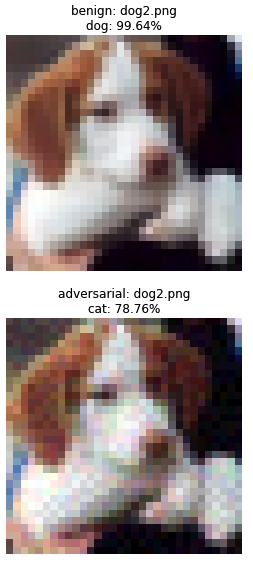

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(cifar_10_mean, cifar_10_std)  # Normalize the image using predefined means and standard deviations
])


model_name = "resnet110_cifar10"
model = ptcv_get_model(model_name, pretrained=True).to(device)

# original image
path = f'dog/dog2.png' # f'airplane/airplane2.png'
im = Image.open(f'./data/{path}')
logit = model(transform(im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'benign: {path}\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

# adversarial image 
attack_name = 'ensemble_ifgsm'
im = Image.open(f'./{attack_name}/{path}')
logit = model(transform(im).unsqueeze(0).to(device))[0]
predict = logit.argmax(-1).item()
prob = logit.softmax(-1)[predict].item()
plt.title(f'adversarial: {path}\n{classes[predict]}: {prob:.2%}')
plt.axis('off')
plt.imshow(np.array(im))
plt.tight_layout()
plt.show()


## Passive Defense - JPEG compression
JPEG compression by imgaug package, compression rate set to 70

Reference: https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html#imgaug.augmenters.arithmetic.JpegCompression

In [ ]:
# import imgaug.augmenters as iaa

# # pre-process image
# x = transforms.ToTensor()(im)*255
# x = x.permute(1, 2, 0).numpy()
# compressed_x = x.astype(np.uint8)

# # TODO: use "imgaug" package to perform JPEG compression (compression rate = 70)
# # compressed_x = ...

# logit = model(transform(compressed_x).unsqueeze(0).to(device))[0]
# predict = logit.argmax(-1).item()
# prob = logit.softmax(-1)[predict].item()
# plt.title(f'JPEG adversarial: dog2.png\n{classes[predict]}: {prob:.2%}')
# plt.axis('off')


# plt.imshow(compressed_x)
# plt.tight_layout()
# plt.show()